In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.get_logger().setLevel('ERROR')

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor, PoisoningAttackCleanLabelBackdoor
from art.attacks.poisoning.perturbations import add_pattern_bd
from art.utils import load_mnist, preprocess, to_categorical
from art.defences.trainer import AdversarialTrainerMadryPGD


from art.estimators.classification.deep_partition_ensemble import DeepPartitionEnsemble

# Load the Data

In [2]:
(x_raw, y_raw), (x_raw_test, y_raw_test), min_, max_ = load_mnist(raw=True)

# Random Selection:
n_train = np.shape(x_raw)[0]
num_selection = 10000
random_selection_indices = np.random.choice(n_train, num_selection)
x_raw = x_raw[random_selection_indices]
y_raw = y_raw[random_selection_indices]

# Poison training data
percent_poison = .33
x_train, y_train = preprocess(x_raw, y_raw)
x_train = np.expand_dims(x_train, axis=3)

x_test, y_test = preprocess(x_raw_test, y_raw_test)
x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

# Initialize the Model Architecture

In [3]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
def create_model():    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Set up the Model Backdoor

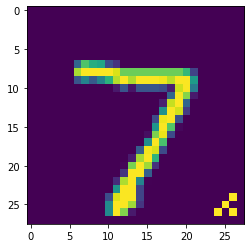

In [4]:
backdoor = PoisoningAttackBackdoor(add_pattern_bd)
example_target = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
pdata, plabels = backdoor.poison(x_test, y=example_target)

plt.imshow(pdata[0].squeeze())

# Create the poison data
For this example, we will select 9 as the target class. Thus, the adversary's goal is to poison the model so adding a trigger will result in the trained model misclassifying the triggered input as a 9.

First, the adversary will create a proxy classifier (i.e., a classifier that is similar to the target classifier). As the clean label attack generates noise using PGD in order to encourage the trained classifier to rely on the trigger, it is important that the generated noise be transferable. Thus, adversarial training is used.

In [5]:
# Poison some percentage of all non-nines to nines
targets = to_categorical([9], 10)[0] 

proxy = AdversarialTrainerMadryPGD(KerasClassifier(create_model()), nb_epochs=10, eps=0.15, eps_step=0.001)
proxy.fit(x_train, y_train)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
attack = PoisoningAttackCleanLabelBackdoor(backdoor=backdoor, proxy_classifier=proxy.get_classifier(),
                                           target=targets, pp_poison=percent_poison, norm=2, eps=5,
                                           eps_step=0.1, max_iter=200)
pdata, plabels = attack.poison(x_train, y_train)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/200 [00:00<?, ?it/s]

1005


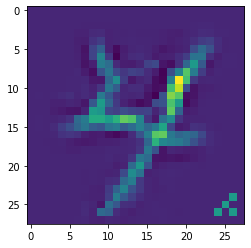

Index: 1 Label: 9


In [7]:
poisoned = pdata[np.all(plabels == targets, axis=1)]
poisoned_labels = plabels[np.all(plabels == targets, axis=1)]
print(len(poisoned))
for i in range(len(poisoned)):
    if poisoned[i][0][0] != 0:
        plt.imshow(poisoned[i].squeeze())
        plt.show()
        print(f"Index: {i} Label: {np.argmax(poisoned_labels[i])}")
        break

# Initialize the classification models
We will initialize four models. The first is a single model architecture. The other three are DPA models with varying ensemble sizes to demonstrate the tradeoff between clean accuracy and poison accuracy. This make take some time because of the model copying.

In [8]:
model = KerasClassifier(create_model())
dpa_model_10 = DeepPartitionEnsemble(model, ensemble_size=10)
dpa_model_20 = DeepPartitionEnsemble(model, ensemble_size=20)
dpa_model_30 = DeepPartitionEnsemble(model, ensemble_size=30)


Train the models on the poisoned data

In [9]:
model.fit(pdata, plabels, nb_epochs=10)
dpa_model_10.fit(pdata, plabels, nb_epochs=10)
dpa_model_20.fit(pdata, plabels, nb_epochs=10)
dpa_model_30.fit(pdata, plabels, nb_epochs=10)

Train on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 106us/sample - loss: 0.6702 - accuracy: 0.7852
Epoch 2/10
10000/10000 [==============================] - 1s 52us/sample - loss: 0.2179 - accuracy: 0.9353
Epoch 3/10
10000/10000 [==============================] - 1s 53us/sample - loss: 0.1370 - accuracy: 0.9567
Epoch 4/10
10000/10000 [==============================] - 1s 51us/sample - loss: 0.1018 - accuracy: 0.9684
Epoch 5/10
10000/10000 [==============================] - 1s 51us/sample - loss: 0.0778 - accuracy: 0.9766
Epoch 6/10
10000/10000 [==============================] - 1s 51us/sample - loss: 0.0661 - accuracy: 0.9783
Epoch 7/10
10000/10000 [==============================] - 1s 51us/sample - loss: 0.0558 - accuracy: 0.9822
Epoch 8/10
10000/10000 [==============================] - 1s 50us/sample - loss: 0.0510 - accuracy: 0.9820
Epoch 9/10
10000/10000 [==============================] - 1s 51us/sample - loss: 0.0435 - accuracy: 0.9862
Epoch 10/10
1

964/964 [==============================] - 0s 53us/sample - loss: 0.2921 - accuracy: 0.9077
Epoch 8/10
964/964 [==============================] - 0s 52us/sample - loss: 0.2208 - accuracy: 0.9315
Epoch 9/10
964/964 [==============================] - 0s 53us/sample - loss: 0.2089 - accuracy: 0.9305
Epoch 10/10
964/964 [==============================] - 0s 52us/sample - loss: 0.1801 - accuracy: 0.9492
Train on 1014 samples
Epoch 1/10
1014/1014 [==============================] - 7s 7ms/sample - loss: 1.8226 - accuracy: 0.4162
Epoch 2/10
1014/1014 [==============================] - 0s 56us/sample - loss: 0.9429 - accuracy: 0.6874
Epoch 3/10
1014/1014 [==============================] - 0s 52us/sample - loss: 0.6000 - accuracy: 0.8116
Epoch 4/10
1014/1014 [==============================] - 0s 50us/sample - loss: 0.4649 - accuracy: 0.8462
Epoch 5/10
1014/1014 [==============================] - 0s 50us/sample - loss: 0.3840 - accuracy: 0.8738
Epoch 6/10
1014/1014 [==============================

510/510 [==============================] - 0s 52us/sample - loss: 0.7577 - accuracy: 0.7373
Epoch 5/10
510/510 [==============================] - 0s 52us/sample - loss: 0.5855 - accuracy: 0.8275
Epoch 6/10
510/510 [==============================] - 0s 53us/sample - loss: 0.4825 - accuracy: 0.8373
Epoch 7/10
510/510 [==============================] - 0s 58us/sample - loss: 0.4021 - accuracy: 0.8765
Epoch 8/10
510/510 [==============================] - 0s 53us/sample - loss: 0.3385 - accuracy: 0.8784
Epoch 9/10
510/510 [==============================] - 0s 52us/sample - loss: 0.2920 - accuracy: 0.9118
Epoch 10/10
510/510 [==============================] - 0s 52us/sample - loss: 0.2465 - accuracy: 0.9275
Train on 540 samples
Epoch 1/10
540/540 [==============================] - 8s 14ms/sample - loss: 2.1399 - accuracy: 0.2907
Epoch 2/10
540/540 [==============================] - 0s 61us/sample - loss: 1.3855 - accuracy: 0.6037
Epoch 3/10
540/540 [==============================] - 0s 57us/

Epoch 2/10
494/494 [==============================] - 0s 58us/sample - loss: 1.5831 - accuracy: 0.5445
Epoch 3/10
494/494 [==============================] - 0s 55us/sample - loss: 0.9799 - accuracy: 0.6842
Epoch 4/10
494/494 [==============================] - 0s 55us/sample - loss: 0.7087 - accuracy: 0.7490
Epoch 5/10
494/494 [==============================] - 0s 57us/sample - loss: 0.5977 - accuracy: 0.8259
Epoch 6/10
494/494 [==============================] - 0s 54us/sample - loss: 0.4985 - accuracy: 0.8462
Epoch 7/10
494/494 [==============================] - 0s 55us/sample - loss: 0.4028 - accuracy: 0.8583
Epoch 8/10
494/494 [==============================] - 0s 55us/sample - loss: 0.3595 - accuracy: 0.8887
Epoch 9/10
494/494 [==============================] - 0s 55us/sample - loss: 0.3189 - accuracy: 0.8947
Epoch 10/10
494/494 [==============================] - 0s 56us/sample - loss: 0.2715 - accuracy: 0.9069
Train on 525 samples
Epoch 1/10
525/525 [==============================]

482/482 [==============================] - 0s 55us/sample - loss: 0.2440 - accuracy: 0.9378
Train on 338 samples
Epoch 1/10
338/338 [==============================] - 9s 25ms/sample - loss: 2.2088 - accuracy: 0.2189
Epoch 2/10
338/338 [==============================] - 0s 65us/sample - loss: 1.7714 - accuracy: 0.4438
Epoch 3/10
338/338 [==============================] - 0s 59us/sample - loss: 1.2951 - accuracy: 0.5947
Epoch 4/10
338/338 [==============================] - 0s 59us/sample - loss: 0.9404 - accuracy: 0.7160
Epoch 5/10
338/338 [==============================] - 0s 59us/sample - loss: 0.7767 - accuracy: 0.7456
Epoch 6/10
338/338 [==============================] - 0s 58us/sample - loss: 0.5287 - accuracy: 0.8314
Epoch 7/10
338/338 [==============================] - 0s 58us/sample - loss: 0.4792 - accuracy: 0.8284
Epoch 8/10
338/338 [==============================] - 0s 58us/sample - loss: 0.3464 - accuracy: 0.8846
Epoch 9/10
338/338 [==============================] - 0s 58us/s

Epoch 8/10
353/353 [==============================] - 0s 58us/sample - loss: 0.4133 - accuracy: 0.8640
Epoch 9/10
353/353 [==============================] - 0s 57us/sample - loss: 0.4101 - accuracy: 0.8754
Epoch 10/10
353/353 [==============================] - 0s 59us/sample - loss: 0.2985 - accuracy: 0.8980
Train on 372 samples
Epoch 1/10
372/372 [==============================] - 1s 2ms/sample - loss: 2.2181 - accuracy: 0.1909
Epoch 2/10
372/372 [==============================] - 0s 57us/sample - loss: 1.7898 - accuracy: 0.5054
Epoch 3/10
372/372 [==============================] - 0s 57us/sample - loss: 1.2460 - accuracy: 0.6344
Epoch 4/10
372/372 [==============================] - 0s 78us/sample - loss: 0.8714 - accuracy: 0.7070
Epoch 5/10
372/372 [==============================] - 0s 58us/sample - loss: 0.7682 - accuracy: 0.7446
Epoch 6/10
372/372 [==============================] - 0s 58us/sample - loss: 0.6201 - accuracy: 0.8145
Epoch 7/10
372/372 [==============================] 

308/308 [==============================] - 0s 61us/sample - loss: 0.6764 - accuracy: 0.7857
Epoch 6/10
308/308 [==============================] - 0s 63us/sample - loss: 0.6220 - accuracy: 0.7500
Epoch 7/10
308/308 [==============================] - 0s 63us/sample - loss: 0.4707 - accuracy: 0.8442
Epoch 8/10
308/308 [==============================] - 0s 62us/sample - loss: 0.3935 - accuracy: 0.8636
Epoch 9/10
308/308 [==============================] - 0s 73us/sample - loss: 0.3467 - accuracy: 0.8994
Epoch 10/10
308/308 [==============================] - 0s 61us/sample - loss: 0.2742 - accuracy: 0.9123
Train on 345 samples
Epoch 1/10
345/345 [==============================] - 1s 2ms/sample - loss: 2.2134 - accuracy: 0.2116
Epoch 2/10
345/345 [==============================] - 0s 60us/sample - loss: 1.7026 - accuracy: 0.5391
Epoch 3/10
345/345 [==============================] - 0s 58us/sample - loss: 1.0985 - accuracy: 0.6870
Epoch 4/10
345/345 [==============================] - 0s 61us/s

Epoch 3/10
377/377 [==============================] - 0s 57us/sample - loss: 1.2591 - accuracy: 0.6605
Epoch 4/10
377/377 [==============================] - 0s 60us/sample - loss: 0.9453 - accuracy: 0.7003
Epoch 5/10
377/377 [==============================] - 0s 57us/sample - loss: 0.7164 - accuracy: 0.7241
Epoch 6/10
377/377 [==============================] - 0s 59us/sample - loss: 0.5858 - accuracy: 0.8276
Epoch 7/10
377/377 [==============================] - 0s 57us/sample - loss: 0.4412 - accuracy: 0.8621
Epoch 8/10
377/377 [==============================] - 0s 59us/sample - loss: 0.3762 - accuracy: 0.8647
Epoch 9/10
377/377 [==============================] - 0s 59us/sample - loss: 0.3873 - accuracy: 0.8568
Epoch 10/10
377/377 [==============================] - 0s 57us/sample - loss: 0.2809 - accuracy: 0.9072
Train on 348 samples
Epoch 1/10
348/348 [==============================] - 10s 29ms/sample - loss: 2.2198 - accuracy: 0.2126
Epoch 2/10
348/348 [==============================

# Evaluate the performance of the trained models on unpoisoned data
The performance of the models appears normal. We see that for the DPA models, the performance drops slightly as the ensemble size increases


Clean test set accuracy (model): 98.04%


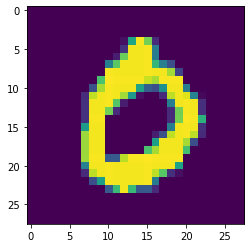

Prediction: 0


In [10]:
clean_preds = np.argmax(model.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (model): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model_10): 93.99%


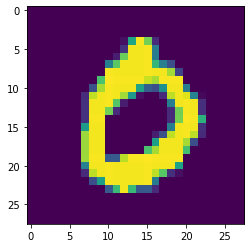

Prediction: 0


In [11]:
clean_preds = np.argmax(dpa_model_10.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_10): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model_20): 91.28%


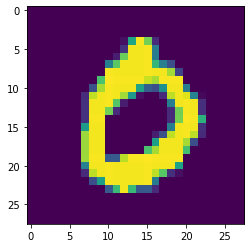

Prediction: 0


In [12]:
clean_preds = np.argmax(dpa_model_20.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_20): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))


Clean test set accuracy (DPA model_30): 89.75%


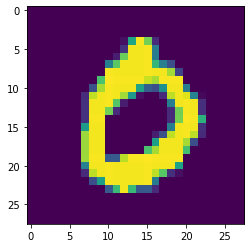

Prediction: 0


In [13]:
clean_preds = np.argmax(dpa_model_30.predict(x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(y_test, axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy (DPA model_30): %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 0 # class to display
i = 0 # image of the class to display

c_idx = np.where(np.argmax(y_test, 1) == c)[0][i] # index of the image in clean arrays

plt.imshow(x_test[c_idx].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(clean_preds[c_idx]))

# Evaluate the performance of the trained models on poisoned data
When the trigger is added, we see a shift in performance. The single model performs the worst as no defense is in place to mitigate the effect of the poisoned. The DPA models show some robustnesss to the poison as they partition the training data, which spreads the effect of the poison between models in the ensemble.


Poison test set accuracy (model): 0.16%


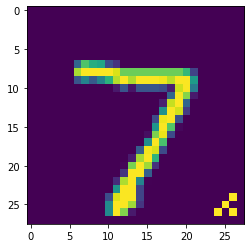

Prediction: 9


In [14]:
not_target = np.logical_not(np.all(y_test == targets, axis=1))
px_test, py_test = backdoor.poison(x_test[not_target], y_test[not_target])

poison_preds = np.argmax(model.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (model): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model_10): 68.20%


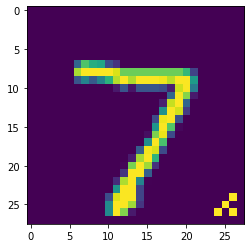

Prediction: 7


In [15]:
poison_preds = np.argmax(dpa_model_10.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_10): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model_20): 74.00%


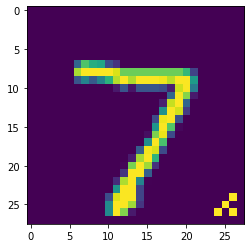

Prediction: 7


In [16]:
poison_preds = np.argmax(dpa_model_20.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_20): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))


Poison test set accuracy (DPA model_30): 74.41%


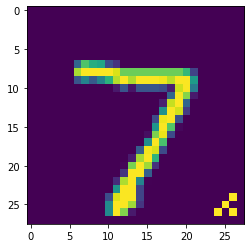

Prediction: 7


In [17]:
poison_preds = np.argmax(dpa_model_30.predict(px_test), axis=1)
clean_correct = np.sum(poison_preds == np.argmax(y_test[not_target], axis=1))
clean_total = y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nPoison test set accuracy (DPA model_30): %.2f%%" % (clean_acc * 100))

c = 0 # index to display
plt.imshow(px_test[c].squeeze())
plt.show()
clean_label = c
print("Prediction: " + str(poison_preds[c]))